> A bit modification to the previous digit classifier. I used log_softmax instead of just softmax. When i used softmax, the accuracy never converged well but while using log_softmax accuracy was going well.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn.functional as F
from torch import nn, optim
import torchvision

plt.style.use('seaborn-whitegrid')

In [2]:
def dataset(file):
    current_datafile = open(file, 'r')
    current_dataset = current_datafile.readlines()
    current_datafile.close()

    datasets = np.zeros([len(current_dataset), 1025])
    indices = np.linspace(0, len(current_dataset) - 1, len(current_dataset), dtype = np.int64)
    np.random.shuffle(indices)
    k = 0
    for i in indices:
        
        example = current_dataset[i].split(',')
        labels = np.asarray(example[0], dtype = np.float32)
        images = np.asarray(example[1:], dtype=np.float32) / 255   
        example = np.hstack([labels, images])
        
        datasets[k] = example
        k = k + 1
    return datasets


In [3]:
train_data = dataset('train.csv')
test_data = dataset('test.csv')
trainloader = th.utils.data.DataLoader(train_data, shuffle = True, batch_size = 32)
testloader = th.utils.data.DataLoader(test_data, shuffle = True, batch_size = 32)

In [4]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 16, 3)
        self.conv3 = nn.Conv2d(16, 8, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 10)
#         self.fc1.weight.data = th.ones()
        self.drop = nn.Dropout2d(0.2)

    def forward(self, x):
        x = self.drop(self.pool(F.relu(self.conv1(x))))
        x = self.drop(self.pool(F.relu(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
#         print(x.shape)
        x = x.view(-1, 32)
        x = self.fc1(x)
        x = F.log_softmax(self.fc2(x))

        return x

    
# Check if model working fine
example = next(iter(trainloader))
label = example[0][0]
example = example[0][1:].float()
example = example.reshape(1, 1, 32, 32)
    
model = Net()

print(label, model(example))

# print(model.fc1.weight.data, model.fc1.weight.data)



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(5., dtype=torch.float64) tensor([[-2.4359, -2.4139, -2.1862, -2.3409, -2.3824, -2.3848, -2.0483, -2.4848,
         -2.1125, -2.3356]], grad_fn=<LogSoftmaxBackward>)


In [5]:
# optimizer = optim.SGD(model.parameters(), weight_decay=1e-6, lr=0.01, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()


In [6]:
epochs = 100
train_losses, test_losses = [], []
train_accuracy = []
for epoch in range(epochs):
    running_loss = 0
    model.train()
    for example in trainloader:
        optimizer.zero_grad()
        
#         print("1: -->", model.fc1.weight.data)
        label = th.Tensor([example[0][0].float()]).long()
        image = th.reshape(example[0][1:].float(), (1, 1, 32, 32))
        
        logps = model(image).reshape(1, 10)  
        loss = criterion(logps, label)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
#         print("2: -->", model.fc1.weight.data)
        
    else:
        model.eval()
        test_loss = 0
        accuracy = 0
        
        with th.no_grad():
            for example in testloader:
                label = th.Tensor([example[0][0].float()]).long()
                image = th.reshape(example[0][1:].float(), (1, 1, 32, 32))
                
#                 print("1: -->", model.fc1.weight.data, model.fc2.weight.data)
                
                logps = model(image).reshape(1, 10) 
                test_loss += criterion(logps, label.long())
#                 print(label, logps)
                ps = th.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == label.view(*top_class.shape)
                accuracy += th.mean(equals.type(th.FloatTensor))
                
#                 priant("2: -->", model.fc1.weight.data, model.fc2.weight.data)
                
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            train_accuracy.append(accuracy / len(testloader))
            
            print("Epoch: {}/{}.. ".format(epoch + 1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}%".format(accuracy/len(testloader) * 100))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/100..  Training Loss: 1.991..  Test Loss: 1.234..  Test Accuracy: 55.319%
Epoch: 2/100..  Training Loss: 1.026..  Test Loss: 0.881..  Test Accuracy: 69.149%
Epoch: 3/100..  Training Loss: 0.832..  Test Loss: 0.778..  Test Accuracy: 76.596%
Epoch: 4/100..  Training Loss: 0.765..  Test Loss: 0.844..  Test Accuracy: 74.468%
Epoch: 5/100..  Training Loss: 0.621..  Test Loss: 0.560..  Test Accuracy: 85.106%
Epoch: 6/100..  Training Loss: 0.595..  Test Loss: 0.441..  Test Accuracy: 85.106%
Epoch: 7/100..  Training Loss: 0.568..  Test Loss: 0.385..  Test Accuracy: 86.170%
Epoch: 8/100..  Training Loss: 0.517..  Test Loss: 0.563..  Test Accuracy: 76.596%
Epoch: 9/100..  Training Loss: 0.482..  Test Loss: 0.282..  Test Accuracy: 91.489%
Epoch: 10/100..  Training Loss: 0.462..  Test Loss: 0.297..  Test Accuracy: 90.426%
Epoch: 11/100..  Training Loss: 0.349..  Test Loss: 0.444..  Test Accuracy: 90.426%
Epoch: 12/100..  Training Loss: 0.431..  Test Loss: 0.411..  Test Accuracy: 86.170%
E

Epoch: 98/100..  Training Loss: 0.192..  Test Loss: 0.044..  Test Accuracy: 98.936%
Epoch: 99/100..  Training Loss: 0.147..  Test Loss: 0.091..  Test Accuracy: 95.745%
Epoch: 100/100..  Training Loss: 0.151..  Test Loss: 0.180..  Test Accuracy: 96.809%


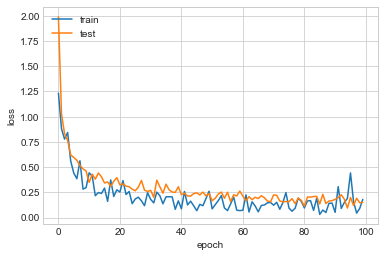

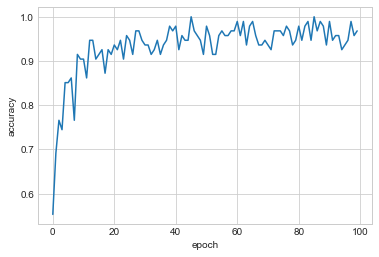

In [7]:
plt.plot(test_losses)
plt.plot(train_losses)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(train_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


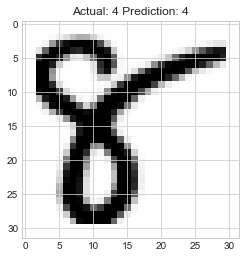

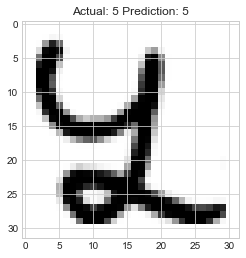

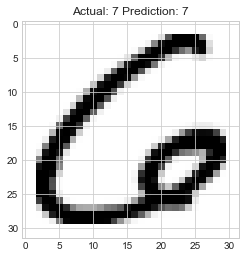

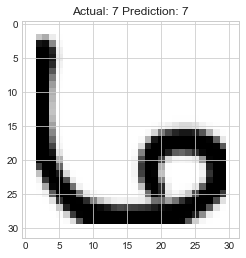

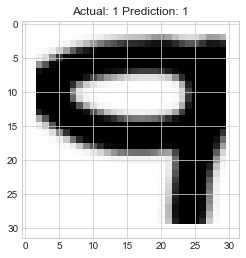

In [8]:
for i in range(5):
    example = next(iter(testloader))

    label = example[0][0]
    image = th.reshape(example[0][1:].float(), (1, 1, 32, 32))
    # image = image.view(image.shape[0], -1)
    prediction = model(image)

    pred_label = th.argmax(prediction)

    title = f"Actual: {int(label)} Prediction: {pred_label}"

    plt.imshow(image.reshape(32, 32))
    plt.title(title)
    plt.show()

In [9]:
th.save(model, 'dcrcnn.ckpt')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [10]:

model = th.load('dcrcnn.ckpt')

In [11]:
device = th.device("cuda")